In [61]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# --- Stehfest 數值反轉 ---
def stehfest_inversion(t, func, args, N=6):
    ln2 = np.log(2)
    def V(k):
        v = 0
        for j in range(int((k+1)/2), min(k, N//2)+1):
            num = j**(N//2) * math.factorial(2*j)
            den = (math.factorial(N//2-j) * math.factorial(j) *
                   math.factorial(j-1) * math.factorial(k-j) * math.factorial(2*j - k))
            v += num / den
        return v * (-1)**(k + N//2)
    result = 0
    for k in range(1, N+1):
        s_k = k * ln2 / t
        result += V(k) * func(s_k, *args)
    return ln2 / t * result

# --- 延遲熱傳模型 Laplace 解 ---
def T_bar_lag(r, s, tau_q, tau_s, q, k, C, r_b):
    try:
        lam = np.sqrt((C * s * (1 + s * tau_q)) / (k * (1 + s * tau_s)))
        K0 = besselk(0, lam * r)
        K1 = besselk(1, lam * r_b)
        if K1 == 0 or np.isnan(K1): return 0
        numerator = -q * (1 + s * tau_q)
        denominator = k * lam * s * (1 + s * tau_s)
        return (numerator / denominator) * (K0 / K1)
    except:
        return 0

def T_lag(r, t, tau_q, tau_s, q, k, C, r_b):
    args = (r, tau_q, tau_s, q, k, C, r_b)
    return stehfest_inversion(t, lambda s, r, tau_q, tau_s, q, k, C, r_b:
                               T_bar_lag(r, s, tau_q, tau_s, q, k, C, r_b), args)

# --- Fourier 傳統模型 ---
def T_bar_fourier(r, s, q, k, C, r_b):
    lam = np.sqrt((C * s) / k)
    K0 = besselk(0, lam * r)
    K1 = besselk(1, lam * r_b)
    if K1 == 0 or np.isnan(K1): return 0
    return (-q / (k * lam * s)) * (K0 / K1)

def T_fourier(r, t, q, k, C, r_b):
    args = (r, q, k, C, r_b)
    return stehfest_inversion(t, lambda s, r, q, k, C, r_b: T_bar_fourier(r, s, q, k, C, r_b), args)

# --- 論文參數 ---
r = 0.2
r_b = 0.2
q = -50 * 3600**3
k = 2.5 * 3600**3
C = 2e6 * 3600**2
t_char = C * r_b**2 / k

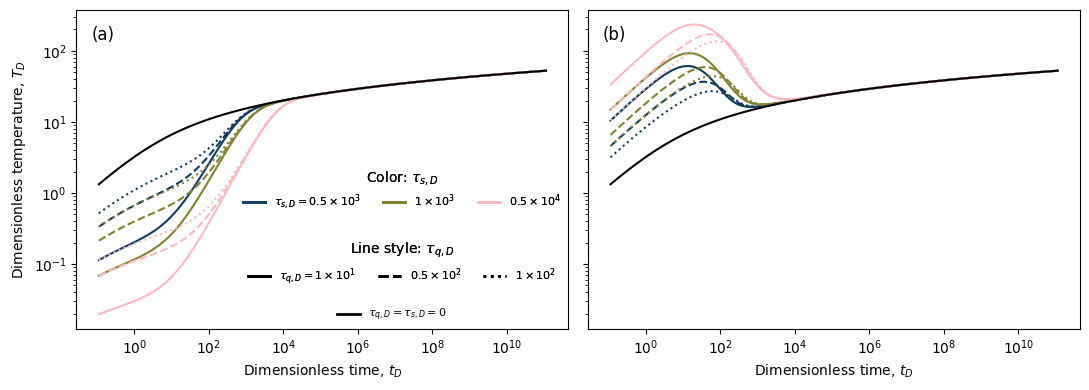

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc          # batlow 調色盤
from matplotlib.lines import Line2D

def sci_tex(val: float) -> str:
    """Return val as '1\\times 10^{a}' (LaTeX-ready)."""
    if val == 0:
        return "0"
    exponent = int(np.round(np.log10(val)))
    mantissa = val / 10**exponent
    # 這裡 mantissa 幾乎永遠是 1，因為你給的數值都是 10 的整次方
    # 如果你想留著通用性，也可以寫成 f"{mantissa:.0f}"
    return rf"{mantissa:.1f}\times 10^{{{exponent}}}"

# ── 時間軸（對數刻度） ────────────────
t_vals   = np.logspace(0, 12, 120)
t_D_vals = t_vals / t_char

# ── 各種視覺設定 ──────────────────────
colors     = cmc.batlow(np.linspace(0.1, 0.9, 3))  # 3 個等距色
markers    = ['o', '^', 's']            # 3 種 marker
linestyles = ['-', '--', ':']           # 3 種線型

fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)  # 1×2 subplot

# ──────────────────────────
#  子圖 (a)： τ_sD > τ_qD
# ──────────────────────────
tau_sDs_a = [5e2, 1e3, 5e3]
tau_qDs_a = [1e1, 5e1, 1e2]

for i, tau_sD in enumerate(tau_sDs_a):
    for j, tau_qD in enumerate(tau_qDs_a):
        tau_s = tau_sD * t_char
        tau_q = tau_qD * t_char
        T_vals      = [T_lag(r, t, tau_q, tau_s, q, k, C, r_b) for t in t_vals]
        T_max       = max(T_vals)
        T_D_vals    = [T for T in T_vals]        
        label = (rf"$\tau_{{s,D}}={sci_tex(tau_sD)},\;"
                 rf"\tau_{{q,D}}={sci_tex(tau_qD)}$")
        axes[0].plot(t_D_vals, T_D_vals,
                     color=colors[i], linestyle=linestyles[j], label=label)
        
        idx = np.round(np.linspace(0, len(t_D_vals)-1, 10)).astype(int)

# 基準解（無延遲）
T_base      = [T_fourier(r, t, q, k, C, r_b) for t in t_vals]
T_D_base    = [T for T in T_base]
axes[0].plot(t_D_vals, T_D_base, color='black', linewidth=1.5,
             label=r"$\tau_{q,D} = \tau_{s,D} = 0$")

# 標題與格式
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel("Dimensionless time, $t_D$")
axes[0].set_ylabel("Dimensionless temperature, $T_D$")
#axes[0].set_yticks(np.arange(0, 13, 2))
axes[0].text(0.03, 0.95, "(a)", transform=axes[0].transAxes,
             va='top', fontsize=12)

# ──────────────────────────
#  子圖 (b)： τ_qD > τ_sD
# ──────────────────────────
tau_qDs_b = [5e2, 1e3, 5e3]
tau_sDs_b = [1e1, 5e1, 1e2]

for i, tau_qD in enumerate(tau_qDs_b):
    for j, tau_sD in enumerate(tau_sDs_b):
        tau_s = tau_sD * t_char
        tau_q = tau_qD * t_char
        T_vals      = [T_lag(r, t, tau_q, tau_s, q, k, C, r_b) for t in t_vals]
        T_max       = max(T_vals)
        T_D_vals    = [T for T in T_vals]
        label = (rf"$\tau_{{s,D}}={sci_tex(tau_sD)},\;"
                 rf"\tau_{{q,D}}={sci_tex(tau_qD)}$")
        axes[1].plot(t_D_vals, T_D_vals,
                     color=colors[i], linestyle=linestyles[j], label=label)
        idx = np.round(np.linspace(0, len(t_D_vals)-1, 10)).astype(int)
        # axes[1].plot(np.array(t_D_vals)[idx], np.array(T_D_vals)[idx],
        #              marker=markers[j], linestyle='None',
        #              color=colors[i], markersize=4)

# 基準解（無延遲）
T_base      = [T_fourier(r, t, q, k, C, r_b) for t in t_vals]
T_D_base    = [T for T in T_base]
axes[1].plot(t_D_vals, T_D_base, color='black', linewidth=1.5,
             label=r"$\tau_{q,D} = \tau_{s,D} = 0$")

# 標題與格式
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel("Dimensionless time, $t_D$")
axes[1].text(0.03, 0.95, "(b)", transform=axes[1].transAxes,
             va='top', fontsize=12)

# # ── 全域圖例：收所有 handle，只顯示一次 ─────────────────
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels,
#            loc='center right',          # 放在兩張圖右側
#            bbox_to_anchor=(0.52, 0.45),  # 微調
#            ncol=1, fontsize=8,          # 一欄、較小字體
#            frameon=False, labelspacing=0.3)

# ── 1. 顏色對映：τ_sD ─────────────────────────────
tau_s_labels = [r"$\tau_{s,D}=0.5\times10^{3}$",
                r"$1\times10^{3}$",
                r"$0.5\times10^{4}$"]
color_handles = [Line2D([0], [0], color=colors[i], lw=2)
                 for i in range(3)]

leg_color = fig.legend(color_handles, tau_s_labels,
                       ncol=3, fontsize=8,
                       title=r"Color: $\tau_{s,D}$",
                       loc="upper center", bbox_to_anchor=(0.37, 0.59),
                       frameon=False)

# ── 2. 線型對映：τ_qD ────────────────────────────
tau_q_labels = [r"$\tau_{q,D}=1\times10^{1}$",
                r"$0.5\times10^{2}$",
                r"$1\times10^{2}$"]
style_handles = [Line2D([0], [0], color="k", lw=2,
                        linestyle=linestyles[j])
                 for j in range(3)]

leg_style = fig.legend(style_handles, tau_q_labels,
                       ncol=3, fontsize=8,
                       title=r"Line style: $\tau_{q,D}$",
                       loc="upper center", bbox_to_anchor=(0.37, 0.41),
                       frameon=False)

# ── 3. 基準解（單獨一項；放在右側或下方都可） ───────────────
base_handle = Line2D([0], [0], color="k", lw=2)
fig.legend([base_handle], [r"$\tau_{q,D}=\tau_{s,D}=0$"],
           loc="center right", bbox_to_anchor=(0.42, 0.2),
           fontsize=8, frameon=False)

# ── 把第一個 legend 加回 figure，使不被第二個覆蓋 ───────────
fig.add_artist(leg_color)
fig.add_artist(leg_style)

plt.tight_layout()
plt.show()

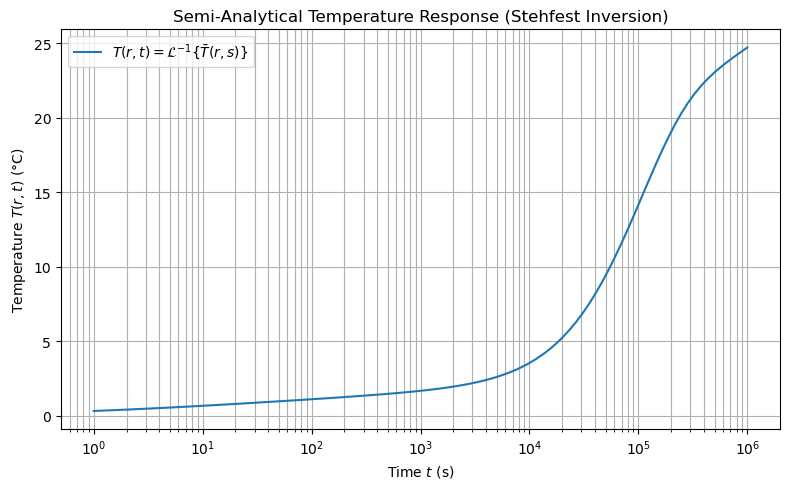

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk
import math

# --- Stehfest 數值反轉方法 ---
def stehfest_inversion(t, func, args, N=12):
    ln2 = np.log(2)
    def V(k):
        v = 0
        for j in range(int((k + 1) / 2), min(k, N // 2) + 1):
            num = j**(N // 2) * math.factorial(2 * j)
            den = (math.factorial(N // 2 - j) * math.factorial(j) *
                   math.factorial(j - 1) * math.factorial(k - j) * math.factorial(2 * j - k))
            v += num / den
        return v * (-1)**(k + N // 2)
    result = 0
    for k in range(1, N + 1):
        s_k = k * ln2 / t
        result += V(k) * func(s_k, *args)
    return ln2 / t * result

# --- 延遲熱傳模型的拉氏域解 ---
def T_bar_lag(r, s, tau_q, tau_s, q, k, C, r_b):
    try:
        lam = np.sqrt((C * s * (1 + s * tau_q)) / (k * (1 + s * tau_s)))
        K0 = besselk(0, lam * r)
        K1 = besselk(1, lam * r_b)
        if K1 == 0 or np.isnan(K1): return 0
        numerator = -q * (1 + s * tau_q)
        denominator = k * lam * s * (1 + s * tau_s)
        return (numerator / denominator) * (K0 / K1)
    except:
        return 0

# --- 時間域解 ---
def T_lag(r, t, tau_q, tau_s, q, k, C, r_b):
    args = (r, tau_q, tau_s, q, k, C, r_b)
    return stehfest_inversion(t, lambda s, r, tau_q, tau_s, q, k, C, r_b:
                               T_bar_lag(r, s, tau_q, tau_s, q, k, C, r_b), args)

# --- 使用者提供的論文參數 ---
r = 0.2
r_b = 0.2
q = -50 * 3600**3        # 熱通量 (W/m)
k = 2.5 * 3600**3        # 熱傳導係數 (W/m/K)
C = 2e6 * 3600**2        # 體積熱容量 (J/m³/K)
t_char = C * r_b**2 / k  # 特徵時間 (s)

# --- 延遲參數（可改）---
tau_q = 1e3 * t_char
tau_s = 1e4 * t_char

# --- 計算溫度曲線 ---
t_vals = np.logspace(0, 6, 100)  # 秒為單位
T_vals = [T_lag(r, t, tau_q, tau_s, q, k, C, r_b) for t in t_vals]

# --- 畫圖 ---
plt.figure(figsize=(8, 5))
plt.plot(t_vals, T_vals, label=r"$T(r,t) = \mathcal{L}^{-1}\{\bar{T}(r,s)\}$")
plt.xscale('log')
plt.xlabel("Time $t$ (s)")
plt.ylabel("Temperature $T(r,t)$ (°C)")
plt.title("Semi-Analytical Temperature Response (Stehfest Inversion)")
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()


<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
C:\Users\LIN\AppData\Local\Temp\ipykernel_20460\1890844742.py:17: SyntaxWarning: invalid escape sequence '\o'
  plt.title("Laplace Domain Solution $\overline{T}_D(r_D)$")
C:\Users\LIN\AppData\Local\Temp\ipykernel_20460\1890844742.py:19: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("$\overline{T}_D$")


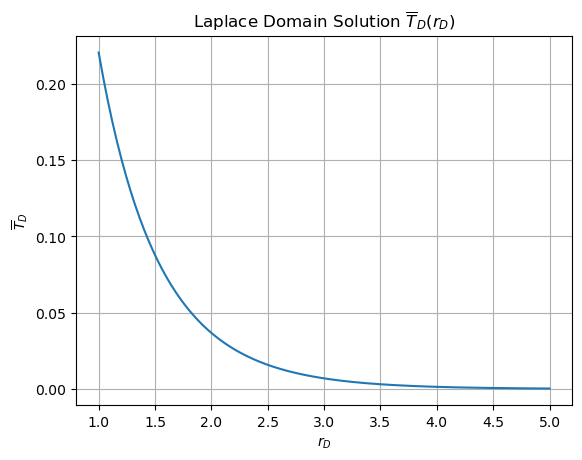

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import k0, k1

# 定義參數
tau_q = 0.1   # 對應 sqD
tau_theta = 0.01  # 對應 ssD
beta = 1.0
p = 1.0       # 拉普拉斯變數（可以嘗試不同值）

lambda_val = np.sqrt((1 + tau_q * p) * (p + beta) / (1 + tau_theta * p))
rD = np.linspace(1, 5, 200)

T_bar = k0(lambda_val * rD)

plt.plot(rD, T_bar)
plt.title("Laplace Domain Solution $\overline{T}_D(r_D)$")
plt.xlabel("$r_D$")
plt.ylabel("$\overline{T}_D$")
plt.grid(True)
plt.show()
